__Final Project__



In [44]:
import simpy
import random
import numpy as np
import pandas as pd
import simpy
import seaborn as sns
from scipy import stats

In [45]:
import random
import simpy
import pandas as pd
import numpy as np
from scipy.stats import norm

# Parameters and Constants
START_TIME = 12 * 3600  # Start time at 12 pm in seconds
ORDER_PROCESSING_TIME_BASE = 1 * 60  # in seconds
ORDER_PROCESSING_TIME_PER_SCOOP = 0.2 * 60  # in seconds
REFILL_TIME = 3 * 60  # in seconds
STORE_HOURS = (12 * 3600, 19 * 3600)  # Store hours from 1 pm to 7 pm in seconds
PEAK_TIMES = [(12 * 3600, 13 * 3600), (17 * 3600, 19 * 3600)]  # Peak times in seconds
BUCKET_SIZE = 80
LAST_CUSTOMER_TIME = 15 * 60  # don't take order 5min until closing

# Define employee shifts in seconds from the start of the store's operation
EMPLOYEE_SHIFTS = [
    (0, 7 * 3600),
    (0, 7 * 3600),
    (0 * 3600, 2 * 3600),
    (5 * 3600, 7 * 3600)
]

EMPLOYEE_SHIFTS_2 = [
    (0, 7 * 3600),
    (0 * 3600, 2 * 3600),
    (5 * 3600, 7 * 3600)
]

FLAVOR_PROBABILITIES = {
    'Vanilla': 0.10,
    'Chocolate': 0.10,
    'Strawberry': 0.05,
    'Mango': 0.02,
    'Pistachio': 0.10,
    'Hazelnut': 0.08,
    'Lemon': 0.02,
    'Coffee': 0.05,
    'Coconut': 0.01,
    'Raspberry': 0.01,
    'Tiramisu': 0.04,
    'Amarena': 0.02,
    'Snickers': 0.08,
    'Straciatela': 0.03,
    'Mint Chocolate': 0.03,
    'Caramel': 0.05,
    'Bacio': 0.01,
    'Fior di Latte': 0.02,
    'Mars': 0.08,
    'Oreo': 0.10
}

FLAVORS = list(FLAVOR_PROBABILITIES.keys())
WEIGHTS = list(FLAVOR_PROBABILITIES.values())

SMALL_CART_FLAVORS = ['Vanilla', 'Chocolate', 'Oreo', 'Caramel', 'Pistachio', 'Hazelnut', 'Lemon', 'Coffee']


**Event Logger**


In [46]:
class EventLogger:
    def __init__(self):
        self.logs = []
        self.replication = None  # Replication number
        self.seed = None  # Seed used for the replication
        self.system_id = None #used to identify the system in the logs
    
    def set_system_id(self, system_id):
        self.system_id = system_id

    def set_replication_info(self, replication, seed):
        self.replication = replication
        self.seed = seed

    def log_event(self, event_time, event_name, customer_id=None, queue_length=None, scoops=None, flavors=None, peak_hours=None, bucket_levels=None, working_employees=None, chosen_stand=None):
        log_entry = {
            'system_id': self.system_id, 
            'replication_id': self.replication,  # Replication info
            'seed': self.seed,  # Seed info
            'event_time': (event_time + START_TIME) / 3600,  # Convert adjusted time to hours
            'event_name': event_name,
            'customer_id': customer_id,
            'queue_length': queue_length,
            'scoops': scoops,
            'flavors': flavors,
            'peak_hours': peak_hours,
            'bucket_levels': bucket_levels,
            'working_employees': working_employees,  # Add working_employees to the log entry
            'chosen_stand': chosen_stand  # Add chosen_stand to the log entry
        }
        self.logs.append(log_entry)
        
    def log_queue_length(self, time, queue_length):
        self.logs.append({'replication_id': self.replication, 'seed': self.seed,  # replication info
                          'event_time': time, 'event_name': 'queue_monitor', 'queue_length': queue_length  # queue length info
        })

    def get_logs_df(self):
        return pd.DataFrame(self.logs)

    def dump_logs_df(self, filepath=None):
        if filepath is None:
            filepath = "logs.csv"
        self.get_logs_df().to_csv(filepath, index=False)

# Event logger instance
event_logger = EventLogger()


**Resources: Ice Cream Shop**
The IceCreamStand class models the ice cream shop, including employees, ice cream buckets, and customer queue.

In [47]:
class IceCreamStand:
    def __init__(self, env, employee_shifts, flavours):
        self.env = env
        self.queue = []
        self.buckets = {flavor: IceCreamBucket(env, flavor) for flavor in flavours}
        self.employees = [Employee(env, self, i, shift) for i, shift in enumerate(employee_shifts)]
        self.env.process(self.log_working_employees())  # Start the logging process

    def join_queue(self, customer, chosen_stand):
        self.queue.append(customer)
        event_logger.log_event(self.env.now, 'Join Queue', customer_id=customer.id, queue_length=len(self.queue), chosen_stand=chosen_stand)
        impatience_event = self.env.timeout(customer.patience)  # Event for the customer's patience timeout
        service_event = self.env.process(self.wait_for_service(customer))  # Event for waiting to be served

        result = yield impatience_event | service_event  # Wait for either the impatience or service event

        if impatience_event in result and not customer.served:
            # Customer left due to impatience
            event_logger.log_event(self.env.now, 'Left Due to Impatience', customer_id=customer.id, queue_length=len(self.queue) - 1, chosen_stand=chosen_stand)
            if customer in self.queue:
                self.queue.remove(customer)  # Remove customer from queue
        else:
            # Customer got served
            customer.served = True
            yield service_event

    def wait_for_service(self, customer):
        while True:
            if customer in self.queue and self.queue[0] == customer:
                yield self.env.timeout(0)  # Customer's turn to be served
                break
            yield self.env.timeout(1)  # Check the queue periodically

    def process_order(self, customer, employee):
        scoops = customer.scoops
        flavors = customer.flavors
        event_logger.log_event(self.env.now, 'Order', customer_id=customer.id, scoops=scoops, flavors=flavors, peak_hours=self.is_peak_time())

        # Processing time for the order
        processing_time = ORDER_PROCESSING_TIME_BASE + ORDER_PROCESSING_TIME_PER_SCOOP * (scoops - 1)
        yield self.env.timeout(processing_time)

        # Serve scoops and log bucket levels after each scoop
        for flavor in flavors:
            if flavor in self.buckets:
                bucket = self.buckets[flavor]
                if bucket.quantity == 0:
                    if not bucket.refilling:
                        bucket.refilling = True
                        employee.working = False  # Mark employee as not working during refill
                        employee.refilling = True  # Mark employee as refilling
                        yield self.env.process(self.refill_bucket(employee, bucket))  # Employee stops to refill the bucket
                        employee.refilling = False  # Mark employee as not refilling
                        employee.working = True  # Mark employee as working after refill
                    while bucket.refilling:
                        yield self.env.timeout(1)  # Wait until the bucket is refilled
                bucket.serve_scoop()
                event_logger.log_event(self.env.now, 'Bucket Level', bucket_levels={flavor: bucket.quantity})
            else:
                event_logger.log_event(self.env.now, 'Flavor Not Available', customer_id=customer.id, flavors=flavor)

        event_logger.log_event(self.env.now, 'Processed', customer_id=customer.id)
        yield self.env.timeout(1 * 60)  # Simulate payment time
        event_logger.log_event(self.env.now, 'Leave', customer_id=customer.id)
        customer.served = True  # Mark the customer as served

    def refill_bucket(self, employee, bucket):
        event_logger.log_event(self.env.now, 'Refill', bucket_levels={bucket.flavor: bucket.quantity})
        yield self.env.timeout(REFILL_TIME)
        bucket.quantity = BUCKET_SIZE
        bucket.refilling = False
        event_logger.log_event(self.env.now, 'Refilled', bucket_levels={bucket.flavor: bucket.quantity})

    def is_peak_time(self):
        current_time = self.env.now + START_TIME
        return any(start <= current_time % 86400 < end for start, end in PEAK_TIMES)

    def log_working_employees(self):
        while True:
            working_employees = sum(1 for employee in self.employees if employee.working and not employee.refilling)
            event_logger.log_event(self.env.now, 'Working Employees', working_employees=working_employees)
            yield self.env.timeout(10 * 60)  # Log every 10 minutes


In [48]:
class IceCreamShop:
    def __init__(self, env, employee_shifts):
        self.env = env
        self.cart = IceCreamStand(env, [(0, 7 * 3600)], SMALL_CART_FLAVORS)  # Small cart with one employee
        self.stand = IceCreamStand(env, employee_shifts, FLAVORS)  # Larger stand with multiple employees

    def join_shorter_queue(self, customer):
        if self.customer_prefers_small_cart(customer):
            if len(self.cart.queue) <= len(self.stand.queue):
                yield self.env.process(self.cart.join_queue(customer, chosen_stand='Cart'))
            else:
                yield self.env.process(self.stand.join_queue(customer, chosen_stand='Stand'))
        else:
            yield self.env.process(self.stand.join_queue(customer, chosen_stand='Stand'))

    def customer_prefers_small_cart(self, customer):
        # Check if the preferred flavors are available in the small cart
        return all(flavor in SMALL_CART_FLAVORS for flavor in customer.flavors)


**Entities: Customer, Employee, IceCreamBucket**

The Customer, Employee, and IceCreamBucket classes model the respective entities in the simulation.

In [49]:
class Customer:
    def __init__(self, env, ice_cream_stand, id):
        self.env = env
        self.ice_cream_stand = ice_cream_stand
        self.id = id
        self.arrival_time = env.now
        self.served = False
        self.patience = random.uniform(10 * 60, 20 * 60)
        self.scoops = random.choices([1, 2, 3, 5], weights=[5, 3, 1, 1])[0]
        self.flavors = random.choices(FLAVORS, WEIGHTS, k=self.scoops)

    def visit_stand(self):
        event_logger.log_event(self.env.now, 'Arrival', self.id, scoops=self.scoops, flavors=self.flavors)
        yield self.env.process(self.ice_cream_stand.join_queue(self, chosen_stand='Stand'))

class Customer_2:
    def __init__(self, env, ice_cream_shop, id):
        self.env = env
        self.ice_cream_shop = ice_cream_shop
        self.id = id
        self.arrival_time = env.now
        self.served = False
        self.patience = random.uniform(10 * 60, 20 * 60)
        self.scoops = random.choices([1, 2, 3, 5], weights=[5, 3, 1, 1])[0]
        self.flavors = random.choices(FLAVORS, WEIGHTS, k=self.scoops)

    def visit_shop(self):
        event_logger.log_event(self.env.now, 'Arrival', self.id, scoops=self.scoops, flavors=self.flavors)
        yield self.env.process(self.ice_cream_shop.join_shorter_queue(self))


In [50]:
class Employee:
    def __init__(self, env, ice_cream_stand, id, shift):
        self.env = env
        self.ice_cream_stand = ice_cream_stand
        self.id = id
        self.shift_start, self.shift_end = shift
        self.working = False  # Track if the employee is working
        self.refilling = False  # Track if the employee is refilling
        self.env.process(self.work())

    def work(self):
        while True:
            current_time = self.env.now
            if self.shift_start <= current_time < self.shift_end:
                if not self.ice_cream_stand.queue or self.refilling:
                    self.working = False  # Not working if no customers or refilling
                    yield self.env.timeout(1)
                    continue

                self.working = True  # Start working
                customer = self.ice_cream_stand.queue.pop(0)
                yield self.env.process(self.ice_cream_stand.process_order(customer, self))
                self.working = True  # Stop working
            else:
                self.working = False  # Not working if shift ended
                yield self.env.timeout(1)

class IceCreamBucket:
    def __init__(self, env, flavor, capacity=BUCKET_SIZE):
        self.env = env
        self.flavor = flavor
        self.capacity = capacity
        self.quantity = capacity
        self.refilling = False  # Add a flag to track refill status

    def serve_scoop(self):
        if self.quantity > 0:
            self.quantity -= 1
        if self.quantity < 10 and not self.refilling:
            self.refilling = True
            self.env.process(self.refill())

    def refill(self):
        event_logger.log_event(self.env.now, 'Refill', bucket_levels={self.flavor: self.quantity})
        yield self.env.timeout(REFILL_TIME)
        self.quantity = BUCKET_SIZE
        self.refilling = False  # Reset the flag after refilling
        event_logger.log_event(self.env.now, 'Refilled', bucket_levels={self.flavor: self.quantity})


**Customer Arrival Process**

The customer_arrivals function generates customers at different intervals for peak and non-peak hours.

In [51]:
# Define the Normal distribution parameters
np_mean, np_std = 61, 45
p_mean, p_std = 42, 41

MAX_CUSTOMERS = 1000

def inverse_transform_normal(mean, std):
    R = np.random.uniform(0, 1)
    return norm.ppf(R, loc=mean, scale=std)

def customer_arrivals_1(env, stand):
    customer_id = 0
    while customer_id < MAX_CUSTOMERS:
        current_time = env.now + START_TIME
        # Stop taking new customers n minutes before the store closes
        if current_time >= STORE_HOURS[1] - LAST_CUSTOMER_TIME:
            break

        # Determine if current time is within peak times
        if any(start <= current_time % 86400 < end for start, end in PEAK_TIMES):
            arrival_interval = inverse_transform_normal(p_mean, p_std)
        else:
            arrival_interval = inverse_transform_normal(np_mean, np_std)

        # Ensure the interval is positive
        arrival_interval = max(0, arrival_interval)

        yield env.timeout(arrival_interval)

        if current_time < STORE_HOURS[0] or current_time >= STORE_HOURS[1]:
            continue

        customer = Customer(env, stand, customer_id)
        env.process(customer.visit_stand())
        customer_id += 1


def customer_arrivals_2(env, shop):
    customer_id = 0
    while customer_id < MAX_CUSTOMERS:
        current_time = env.now + START_TIME
        # Stop taking new customers n minutes before the store closes
        if current_time >= STORE_HOURS[1] - LAST_CUSTOMER_TIME:
            break

        # Determine if current time is within peak times
        if any(start <= current_time % 86400 < end for start, end in PEAK_TIMES):
            arrival_interval = inverse_transform_normal(p_mean, p_std)
        else:
            arrival_interval = inverse_transform_normal(np_mean, np_std)

        # Ensure the interval is positive
        arrival_interval = max(0, arrival_interval)

        yield env.timeout(arrival_interval)

        if current_time < STORE_HOURS[0] or current_time >= STORE_HOURS[1]:
            continue

        customer = Customer_2(env, shop, customer_id)
        env.process(customer.visit_shop())
        customer_id += 1


**Running simulation**


In [52]:
# Running simulation
print('Running Simulation...')
N_REPLICATIONS = 8  # Number of Replications

# Compute a pool of seeds that is larger than the number of replications
safe_factor = 10
pool_of_seeds = range(1, N_REPLICATIONS * safe_factor)

# Get a list of seeds of length: N_REPLICATIONS from a pool of seeds. 
# We set replace=False to ensure that we don't reuse the same seed twice.
list_of_seeds = np.random.choice(pool_of_seeds, size=N_REPLICATIONS, replace=False)
print(list_of_seeds)

for i, seed in enumerate(list_of_seeds):
    print(f'Running Replication {i} with seed: {seed} ...')

    # Set random seed
    np.random.seed(seed)

    # Set replication id and random seed
    event_logger.set_replication_info(i, seed)

    ######################################
    ############## SYSTEM 1 ##############
    ######################################

    # Set system id
    event_logger.set_system_id(1)

    # Create an environment and start the setup process
    env = simpy.Environment()

    # Define resources
    stand = IceCreamStand(env, EMPLOYEE_SHIFTS, FLAVORS)
    
    # Define processes
    env.process(customer_arrivals_1(env, stand))

    # Execute
    env.run(until=STORE_HOURS[1] - START_TIME)

    # Set random seed
    np.random.seed(seed)
    
    ######################################
    ############## SYSTEM 2 ##############
    ######################################

    # Set system id
    event_logger.set_system_id(2)

    # Create an environment and start the setup process
    env = simpy.Environment()

    # Define resources
    shop = IceCreamShop(env, EMPLOYEE_SHIFTS_2)
    
    # Define processes
    env.process(customer_arrivals_2(env, shop))

    # Execute
    env.run(until=STORE_HOURS[1] - START_TIME)

    # Log the store closing time
    event_logger.log_event(env.now, 'Store closes')

print('... Done')


Running Simulation...
[71 65 43 63 52 14 68 38]
Running Replication 0 with seed: 71 ...
Running Replication 1 with seed: 65 ...
Running Replication 2 with seed: 43 ...
Running Replication 3 with seed: 63 ...
Running Replication 4 with seed: 52 ...
Running Replication 5 with seed: 14 ...
Running Replication 6 with seed: 68 ...
Running Replication 7 with seed: 38 ...
... Done


In [53]:
event_logger.dump_logs_df('Extra_Cart.csv')
logs_df = event_logger.get_logs_df()
logs_df

,system_id,replication_id,seed,event_time,event_name,customer_id,queue_length,scoops,flavors,peak_hours,bucket_levels,working_employees,chosen_stand
0,1,0,71,12.000000,Working Employees,NaN,NaN,NaN,None,None,None,0.0,None
1,1,0,71,12.001481,Arrival,0.0,NaN,2.0,"[Hazelnut, Chocolate]",None,None,NaN,None
2,1,0,71,12.001481,Join Queue,0.0,1.0,NaN,None,None,None,NaN,Stand
3,1,0,71,12.001667,Order,0.0,NaN,2.0,"[Hazelnut, Chocolate]",True,None,NaN,None
4,1,0,71,12.009866,Arrival,1.0,NaN,1.0,[Mars],None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49686,2,7,38,18.874167,Order,447.0,NaN,1.0,[Oreo],True,None,NaN,None
49687,2,7,38,18.890833,Bucket Level,NaN,NaN,NaN,None,None,{'Oreo': 45},NaN,None
49688,2,7,38,18.890833,Processed,447.0,NaN,NaN,None,None,None,NaN,None
49689,2,7,38,18.907500,Leave,447.0,NaN,NaN,None,None,None,NaN,None


Checking if we have implemente the common random numbers correctly

In [54]:
boolean_mask = (logs_df['replication_id'] == 0) & (logs_df['customer_id'].isin([1, 2]) )

logs_df[boolean_mask].sort_values(by=['customer_id', 'event_name', 'system_id'])

,system_id,replication_id,seed,event_time,event_name,customer_id,queue_length,scoops,flavors,peak_hours,bucket_levels,working_employees,chosen_stand
4,1,0,71,12.009866,Arrival,1.0,NaN,1.0,[Mars],None,None,NaN,None
3093,2,0,71,12.009866,Arrival,1.0,NaN,1.0,[Chocolate],None,None,NaN,None
5,1,0,71,12.009866,Join Queue,1.0,1.0,NaN,None,None,None,NaN,Stand
3094,2,0,71,12.009866,Join Queue,1.0,1.0,NaN,None,None,None,NaN,Cart
19,1,0,71,12.043333,Leave,1.0,NaN,NaN,None,None,None,NaN,None
3109,2,0,71,12.043333,Leave,1.0,NaN,NaN,None,None,None,NaN,None
6,1,0,71,12.010000,Order,1.0,NaN,1.0,[Mars],True,None,NaN,None
3095,2,0,71,12.010000,Order,1.0,NaN,1.0,[Chocolate],True,None,NaN,None
11,1,0,71,12.026667,Processed,1.0,NaN,NaN,None,None,None,NaN,None
3097,2,0,71,12.026667,Processed,1.0,NaN,NaN,None,None,None,NaN,None


In [55]:
# Pivot the DataFrame and reset index
results_df = pd.pivot_table(logs_df, index=["system_id", "customer_id", "replication_id", "seed"], 
                            columns=["event_name"], values="event_time").reset_index()

# Compute waiting time and total time spent
results_df['Waiting_time'] = results_df['Processed'] - results_df['Arrival']

# Calculate total time spent, considering both 'Leave' and 'Left Due to Impatience'
results_df['Total_time_spent'] = results_df[['Leave', 'Left Due to Impatience']].max(axis=1) - results_df['Arrival']

# Sort by system_id, replication_id, and Arrival time, then compute interarrival times
results_df.sort_values(by=['system_id', 'replication_id', 'Arrival'], inplace=True)
results_df['iat'] = results_df.groupby(['system_id', 'replication_id'])['Arrival'].diff().fillna(0)

# Pivot the queue length data and merge it with the results_df
queue_length_df = pd.pivot_table(logs_df, index=["system_id", "customer_id", "replication_id", "seed"], 
                                 columns=["event_name"], values="queue_length").reset_index()
results_df = results_df.merge(queue_length_df, on=["system_id", "customer_id", "replication_id", "seed"], 
                              suffixes=('', '_queue_length'))

# Rename columns for clarity and drop unnecessary columns
results_df.rename(columns={
    'Join Queue': 'Queue_Join_Time',
    'Leave_queue_length': 'Queue_Length_At_Leave',
    'Join Queue_queue_length': 'Queue_Length_At_Join'
}, inplace=True)
results_df.drop(columns=['Queue_Join_Time'], inplace=True)

# Reorder columns
new_order = ['system_id', 'customer_id', 'replication_id', 'seed', 'Arrival', 'Order', 'Processed', 
             'Leave', 'Waiting_time', 'Total_time_spent', 'iat', 'Queue_Length_At_Join']
results_df = results_df[new_order]

results_df

event_name,system_id,customer_id,replication_id,seed,Arrival,Order,Processed,Leave,Waiting_time,Total_time_spent,iat,Queue_Length_At_Join
0,1,0.0,0,71,12.001481,12.001667,12.021667,12.038333,0.020185,0.036852,0.000000,1.0
1,1,1.0,0,71,12.009866,12.010000,12.026667,12.043333,0.016801,0.033468,0.008384,1.0
2,1,2.0,0,71,12.032485,12.032500,12.049167,12.065833,0.016682,0.033348,0.022619,1.0
3,1,3.0,0,71,12.034513,12.038333,12.055000,12.071667,0.020487,0.037153,0.002028,1.0
4,1,4.0,0,71,12.061923,12.061944,12.078611,12.095278,0.016688,0.033355,0.027409,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7141,2,445.0,7,38,18.671014,18.771667,18.791667,18.808333,0.120652,0.137319,0.028529,6.0
7142,2,446.0,7,38,18.695003,18.785278,18.801944,18.818611,0.106941,0.123608,0.023989,6.0
7143,2,447.0,7,38,18.715621,18.874167,18.890833,18.907500,0.175212,0.191879,0.020618,5.0
7144,2,448.0,7,38,18.735520,18.808333,18.825000,18.841667,0.089480,0.106147,0.019898,4.0


In [56]:
# Group by replication_id and calculate mean and standard deviation of Waiting_time
replication_results = results_df.groupby(["system_id", "replication_id"]).agg(
    waiting_time_mean=pd.NamedAgg(column="Waiting_time", aggfunc="mean"),
    waiting_time_std=pd.NamedAgg(column="Waiting_time", aggfunc="std"),
).reset_index()

print(replication_results.shape)
#show the first 5 rows
replication_results.head()

(16, 4)


,system_id,replication_id,waiting_time_mean,waiting_time_std
0,1,0,0.067099,0.038862
1,1,1,0.128935,0.063433
2,1,2,0.067552,0.042733
3,1,3,0.089862,0.068454
4,1,4,0.075612,0.061404


In [57]:
epsilon = 0.05
alpha = 0.05

R0 = replication_results.shape[0]

t_value = stats.t.ppf(1 - alpha / 2, R0 - 1)

s0 = replication_results['waiting_time_std'].mean()

R = ((t_value * s0)/ epsilon)**2

print(f"The required number of replications is: {round(R)}")

The required number of replications is: 8


In [58]:
def sample_size_calculator(alpha, epsilon, s0, R0):

    t_value = stats.t.ppf(1 - alpha / 2, R0 - 1)

    R = ((t_value * s0)/ epsilon)**2
    R = np.ceil(R)
    return R

In [59]:

#define epsilon and alpha ranges
epsilon_values = np.arange(0.05, 1.0, 0.05)
alpha_values = np.arange(0.05, 1.0, 0.05)

data = []

#iterate over epsilon and alpha values
for epsilon in epsilon_values:
    for alpha in alpha_values:
        
        #compute sample size
        try:
            R = sample_size_calculator(alpha, epsilon, s0, R0)
        except OverflowError:
            R = np.nan

        #append results to data
        data.append({'alpha': round(alpha, 2), 'epsilon': round(epsilon, 2), 'sample_size': R})
        
#convert data to DataFrame and pivot
df = pd.DataFrame(data)
df= df.pivot(index="alpha", columns="epsilon", values="sample_size")

df

epsilon,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
alpha,,,,,,,,,,,,,,,,,,,
0.05,9.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.10,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.15,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.20,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.25,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.30,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.35,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.40,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.45,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<Axes: xlabel='epsilon', ylabel='alpha'>

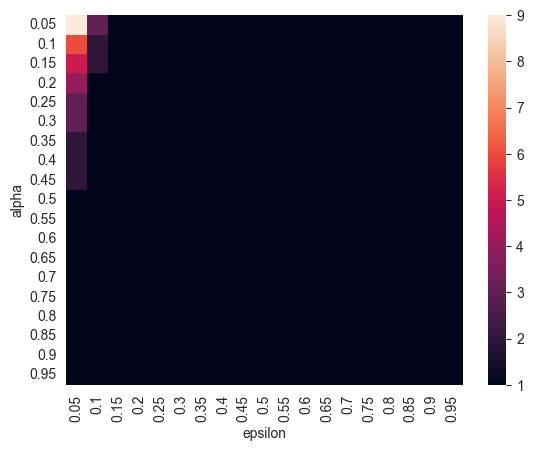

In [60]:
#Leave this code unchanged
sns.heatmap(df)